# Taxi / Shared mobility

The standard vehicles (added by default `addVehicle` or `adddemand`)in UXsim are a kind of privately owned vehicles: They travel from origin to destination and disappear. 

In this demonstration, we explain how to represent taxi-like (or *shared mobility* if you want a cool name) vehicles that repeatedly transport multiple passengers. Such taxi can be added by `addVehicle` with `mode="taxi"` option. Furthermore, the passenger-to-taxi matching problem is handled by `uxsim.TaxiHandler` submodule.

Let's define a grid shaped network scenario.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from pylab import *
from uxsim import *
from uxsim.TaxiHandler import *

# World definition
tmax = 7200
deltan = 5
W = World(
    name="",
    deltan=deltan,
    tmax=tmax,
    print_mode=1, save_mode=1, show_mode=1,
    random_seed=0,
)

# Scenario definition: grid network
#deploy nodes as an imax x jmax grid
imax = 6
jmax = 6
nodes = {}
for i in range(imax):
    for j in range(jmax):
        nodes[i,j] = W.addNode(f"n{(i,j)}", i, j, flow_capacity=1.6)

#create links between neighborhood nodes
links = {}
for i in range(imax):
    for j in range(jmax):
        if i != imax-1:
            links[i,j,i+1,j] = W.addLink(f"l{(i,j,i+1,j)}", nodes[i,j], nodes[i+1,j], length=1000, free_flow_speed=20, number_of_lanes=1)
        if i != 0:
            links[i,j,i-1,j] = W.addLink(f"l{(i,j,i-1,j)}", nodes[i,j], nodes[i-1,j], length=1000, free_flow_speed=20, number_of_lanes=1)
        if j != jmax-1:
            links[i,j,i,j+1] = W.addLink(f"l{(i,j,i,j+1)}", nodes[i,j], nodes[i,j+1], length=1000, free_flow_speed=20, number_of_lanes=1)
        if j != 0:
            links[i,j,i,j-1] = W.addLink(f"l{(i,j,i,j-1)}", nodes[i,j], nodes[i,j-1], length=1000, free_flow_speed=20, number_of_lanes=1)

Taxis can be added by `W.addVehicle(origin_node, None, 0, mode="taxi")` as follows. Their behavior is as follows:
- When it has no job, it circulates the network randomly.
- When it is ordered to serve a passenger, it travels to the origin node of the passenger to pickup, and then travels to the destination to drop-off.

In addition, we need to define a taxi handler `Handler`. It is responsible to manage trip requests from passengers and give orders to taxis. This time, we use default `TaxiHandler_nearest` that matches a new passenger to their nearest vacant taxi.

In [3]:
Handler = TaxiHandler_nearest(W)

n_taxis = 3000
for i in range(int(n_taxis/deltan)):
    node = random.choice(list(nodes.values()))
    W.addVehicle(node, None, 0, mode="taxi")

Passengers' trip requests can be added by `Handler.add_trip_request(origin_node, destination_node, departure_time)`. In this scenario, they are randomly set as follows.

In [4]:
n_passengers = 10000
for i in range(int(n_passengers/deltan)):
    node1 = random.choice(list(nodes.values()))
    node2 = random.choice(list(nodes.values()))
    while node1 == node2:
        node2 = random.choice(list(nodes.values()))
    Handler.add_trip_request(node1, node2, i/n_passengers*tmax/2)

Now we can execute simulation. During the simulation, `Handler.assign_trip_request_to_taxi()` must be called repeatedly in order to let taxis do their jobs.

In [5]:
# Run the simulation 
while W.check_simulation_ongoing():
    W.exec_simulation(duration_t = 60)
    Handler.assign_trip_request_to_taxi() # for every 60 seconds, the taxi is assgined

# Results
W.analyzer.print_simple_stats()

simulation setting:
 scenario name: 
 simulation duration:	 7200 s
 number of vehicles:	 3000 veh
 total road length:	 120000 m
 time discret. width:	 5 s
 platoon size:		 5 veh
 number of timesteps:	 1440
 number of platoons:	 600
 number of links:	 120
 number of nodes:	 36
 setup time:		 0.29 s
simulating...
      time| # of vehicles| ave speed| computation time
       0 s|        0 vehs|   0.0 m/s|     0.00 s
     600 s|     3000 vehs|  10.6 m/s|     0.95 s
    1200 s|     3000 vehs|  11.0 m/s|     1.50 s
    1800 s|     3000 vehs|  13.6 m/s|     2.06 s
    2400 s|     3000 vehs|  14.2 m/s|     2.60 s
    3000 s|     3000 vehs|  14.1 m/s|     3.28 s
    3600 s|     3000 vehs|  14.1 m/s|     3.81 s
    4200 s|     3000 vehs|  15.1 m/s|     4.36 s
    4800 s|     3000 vehs|  14.7 m/s|     4.88 s
    5400 s|     3000 vehs|  14.3 m/s|     5.39 s
    6000 s|     3000 vehs|  14.8 m/s|     5.90 s
    6600 s|     3000 vehs|  14.9 m/s|     6.43 s
    7195 s|     3000 vehs|  14.6 m/s|     6.

The summary of taxi transportation can be printed as follows

In [6]:
Handler.print_stats()

results for taxi transportation:
 total trip rquests: 10000
 completed trip requests: 10000
 completed trip requests ratio:  1.00
 average number of completed requests per taxi:  3.33
 average waiting time:  402.6
 average in-vehicle time:  354.6
 average trip time:  757.3


You can also export the trip logs as pandas.Dataframe.

In [7]:
df = Handler.trips_to_pandas()
display(df)

,orig,dest,depart_time,get_taxi_time,arrival_time,travel_time,waiting_time,used_taxi
0,"n(3, 2)","n(2, 2)",0.00,150,225,225.00,150.00,97
1,"n(1, 5)","n(4, 5)",0.36,150,300,299.64,149.64,267
2,"n(3, 2)","n(4, 4)",0.72,55,260,259.28,54.28,108
3,"n(2, 2)","n(2, 5)",1.08,150,325,323.92,148.92,48
4,"n(2, 0)","n(1, 0)",1.44,180,235,233.56,178.56,7
...,...,...,...,...,...,...,...,...
1995,"n(4, 2)","n(4, 1)",718.20,1580,1655,936.80,861.80,293
1996,"n(2, 2)","n(1, 0)",718.56,1645,1805,1086.44,926.44,566
1997,"n(2, 2)","n(2, 5)",718.92,1775,1950,1231.08,1056.08,523
1998,"n(4, 4)","n(1, 2)",719.28,1590,2120,1400.72,870.72,139


## How many taxis do we need in a city?

This is an important question (even [a Nature article](https://www.nature.com/articles/s41586-018-0095-1) addresses this issue). If the number of taxis is too small, it cannot provide sufficient services to the travelers. Contrary, if it is too large, the road get congested and the travel time will be increased.

Let's answer this question using UXsim. First, we define simulation scenario as a function whose variable is the number of taxis and the number of passengers. The scenario setting is very similar to the previous example. This function returns some stats of the simulation results.

In [8]:
from pylab import *
from uxsim import *
from uxsim.TaxiHandler import *

def simulation_with_given_number_of_taxis(n_taxis, n_passengers):
    print("####"*20)
    print(f"CASE WTIH NUMBER OF TAXIS = {n_taxis}")

    # World definition
    tmax = 7200
    deltan = 5
    W = World(
        name="",
        deltan=deltan,
        tmax=tmax,
        print_mode=0, save_mode=1, show_mode=1,
        random_seed=0,
    )

    # Scenario definition: grid network
    #deploy nodes as an imax x jmax grid
    imax = 6
    jmax = 6
    nodes = {}
    for i in range(imax):
        for j in range(jmax):
            nodes[i,j] = W.addNode(f"n{(i,j)}", i, j, flow_capacity=1.6)

    #create links between neighborhood nodes
    links = {}
    for i in range(imax):
        for j in range(jmax):
            if i != imax-1:
                links[i,j,i+1,j] = W.addLink(f"l{(i,j,i+1,j)}", nodes[i,j], nodes[i+1,j], length=1000, free_flow_speed=20, number_of_lanes=1)
            if i != 0:
                links[i,j,i-1,j] = W.addLink(f"l{(i,j,i-1,j)}", nodes[i,j], nodes[i-1,j], length=1000, free_flow_speed=20, number_of_lanes=1)
            if j != jmax-1:
                links[i,j,i,j+1] = W.addLink(f"l{(i,j,i,j+1)}", nodes[i,j], nodes[i,j+1], length=1000, free_flow_speed=20, number_of_lanes=1)
            if j != 0:
                links[i,j,i,j-1] = W.addLink(f"l{(i,j,i,j-1)}", nodes[i,j], nodes[i,j-1], length=1000, free_flow_speed=20, number_of_lanes=1)

    # taxis and passengers
    for i in range(int(n_taxis/deltan)):
        node = random.choice(list(nodes.values()))
        W.addVehicle(node, None, 0, mode="taxi")

    Handler = TaxiHandler_nearest(W)
    for i in range(int(n_passengers/deltan)):
        node1 = random.choice(list(nodes.values()))
        node2 = random.choice(list(nodes.values()))
        while node1 == node2:
            node2 = random.choice(list(nodes.values()))
        Handler.add_trip_request(node1, node2, i/n_passengers*tmax/2)

    # Run the simulation 
    while W.check_simulation_ongoing():
        W.exec_simulation(duration_t = 60)
        Handler.assign_trip_request_to_taxi() # for every 60 seconds, the taxi is assgined

    # Results
    W.analyzer.print_simple_stats()

    Handler.print_stats()

    df_veh = W.analyzer.vehicles_to_pandas()

    # Return the average travel time, waiting time, and vehicle speed
    return average(Handler.travel_times), average(Handler.waiting_times), average(df_veh["v"])

Then we systematically execute simulation scenarios with different number of taxis. The total traveler demand is fixed.

In [9]:
res_passenger_travel_time = {}
res_passenger_waiting_time = {}
res_vehicle_speed = {}

for n_taxis in range(1000, 10001, 1000):
    ptt, pwt, vs = simulation_with_given_number_of_taxis(n_taxis, 10000)
    res_passenger_travel_time[n_taxis] = ptt
    res_passenger_waiting_time[n_taxis] = pwt
    res_vehicle_speed[n_taxis] = vs

################################################################################
CASE WTIH NUMBER OF TAXIS = 1000
results for taxi transportation:
 total trip rquests: 10000
 completed trip requests: 10000
 completed trip requests ratio:  1.00
 average number of completed requests per taxi:  10.00
 average waiting time:  1230.0
 average in-vehicle time:  199.5
 average trip time:  1429.6
################################################################################
CASE WTIH NUMBER OF TAXIS = 2000
results for taxi transportation:
 total trip rquests: 10000
 completed trip requests: 10000
 completed trip requests ratio:  1.00
 average number of completed requests per taxi:  5.00
 average waiting time:  500.7
 average in-vehicle time:  230.4
 average trip time:  731.0
################################################################################
CASE WTIH NUMBER OF TAXIS = 3000
results for taxi transportation:
 total trip rquests: 10000
 completed trip requests: 10000
 completed trip

Now visualize the results.

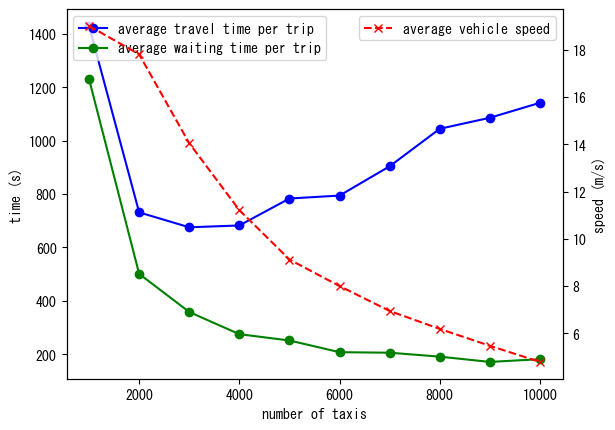

In [10]:
figure()
ax1 = gca()
ax1.plot(list(res_passenger_travel_time.keys()), list(res_passenger_travel_time.values()), "bo-", label="average travel time per trip")
ax1.plot(list(res_passenger_waiting_time.keys()), list(res_passenger_waiting_time.values()), "go-", label="average waiting time per trip")
ax1.set_xlabel("number of taxis")
ax1.set_ylabel("time (s)")

ax2 = ax1.twinx()
ax2.plot(list(res_vehicle_speed.keys()), list(res_vehicle_speed.values()), "rx--", label="average vehicle speed")
ax2.set_ylabel("speed (m/s)")

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

show()

You can see that the waiting time monotonically decreases as the number of taxis increases. At the same time, the average speed of vehicles monotonically decreases as the the number of taxis increases, resulting long travel time after some point. 

As a result, the optimal number of taxis (that balances both of these factors and minimizes the passenger travel time) is found to be around 3000. This means that 1 taxi serves to 3 passengers in 1-2 hours in this city. Sounds reasonable.

## Defining custom TaxiHandler

You can also define your won TaxiHandler that may have smarter passenger-to-vehicle matching or even ridesharing. To do so, it is recommended to define a custom class by inheriting `TaxiHandler` class. 


Below is an example of (slightly) advanced taxi handler.
Important built-in variables and functions:
- `TaxiHandler.trip_requests`: A list of all of the trip requests that is handled by `TaxiHandler`
- `TaxiHandler.assign_taxi(taxi, trip_request)`: This assigns `taxi` to `trip_request`. The `taxi` immediately start traveling to pickup the `trip_request` once this function is called.

For the details, please see the source code of `uxsim/TaxiHandler/TaxiHandler.py`

In [11]:
from uxsim.TaxiHandler import *

class TaxiHandler_nearest_matching_radious(TaxiHandler):
    """
    A taxi handler that assigns trip requests to nearest taxis that are within a certain radious of the origin node (based on Euclidean distance). 
    """
    def __init__(s, W, matching_radious):
        super().__init__(W)
        s.matching_radious = matching_radious
    
    def assign_trip_request_to_taxi(s):
        """
        Assigns trip request to nearest available taxi that is within the radious of the origin node.
        """
        vacant_taxis = [veh for veh in s.W.VEHICLES.values() if veh.mode == "taxi" and veh.state == "run" and veh.dest == None]
        random.shuffle(vacant_taxis)
        for trip_request in s.trip_requests[:]:
            if len(vacant_taxis) == 0:
                break
            if trip_request.depart_time <= s.W.TIME:
                dist_tmp = float("inf")
                taxi_tmp = None
                for taxi in vacant_taxis[:]:
                    x0, y0 = taxi.get_xy_coords()
                    x1, y1 = trip_request.orig.x, trip_request.orig.y
                    dist = math.sqrt((x0-x1)**2 + (y0-y1)**2)
                    if dist <= s.matching_radious and dist <= dist_tmp:
                        dist_tmp = dist
                        taxi_tmp = taxi
                if taxi_tmp != None:
                    vacant_taxis.remove(taxi_tmp)
                    s.assign_taxi(taxi_tmp, trip_request)

FYI, the following is an explanation by GPT-4 that I proofread for accuracy.
The function `assign_trip_request_to_taxi` is designed to assign trip requests to the nearest available taxi within a specified radius of the request's origin point. Here's a detailed explanation for its functionality:

**Description**

This function assigns each trip request to the nearest available taxi that is within the radius of the trip's origin node. It ensures that trip requests are matched efficiently to taxis that are not currently occupied and are in a state ready to run.

**Workflow**

1. **Identify Vacant Taxis**:
   - The function starts by filtering out all vehicles from `s.W.VEHICLES` that are marked as taxis (`veh.mode == "taxi"`), are in the running state (`veh.state == "run"`), and are not currently assigned to a destination to carry travelers (`veh.dest == None`).

2. **Process Each Trip Request**:
   - It iterates over all current trip requests.
   - If there are no vacant taxis left, it breaks out of the loop as no more assignments can be made.
   - For each trip request, it checks if the request's departure time is less than or equal to the current world time (`s.W.TIME`).

3. **Find the Nearest Available Taxi**:
   - For each trip request being processed, it initializes a variable to track the smallest distance found (`dist_tmp`) and a variable to hold the nearest taxi (`taxi_tmp`).
   - It then calculates the distance between the trip request's origin and each taxi's current coordinates using the Euclidean distance formula.
   - If a taxi is within the allowed matching radius (`s.matching_radious`) and closer than any previously checked taxi, it updates `taxi_tmp` to this taxi.

4. **Assign the Taxi**:
   - If a nearest taxi (`taxi_tmp`) is found for a trip request, the taxi is removed from the list of vacant taxis to prevent it from being assigned to multiple requests.
   - The taxi is then officially assigned to the trip request using `s.assign_taxi(taxi_tmp, trip_request)`.

**Notes**
- The function assumes that there are methods and attributes within the object `s` that allow it to access current time (`s.W.TIME`), vehicle list (`s.W.VEHICLES`), and the function `assign_taxi` to handle the assignment.
- The radius within which a taxi can be matched to a trip request is defined by `s.matching_radious`.
- This function ensures that taxis are utilized efficiently by assigning them to the closest requests, thereby potentially reducing wait times for passengers and travel distances for taxis.
